# Data Preprocessing

In [ ]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
from operator import itemgetter
import random
import scipy
from scipy.ndimage.filters import gaussian_filter
import scipy.spatial
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.optim as optim
import math
from imgaug import augmenters as iaa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#reading data directions 
dir = []
dir_test = []

for name in sorted(glob.glob('/content/drive/My Drive/Colab Notebooks/part_B/train_data/images/*.jpg')):  #train direstion
    dir.append(name)

for name in sorted(glob.glob('/content/drive/My Drive/Colab Notebooks/part_B/test_data/images/*.jpg')):   #test direstion
    dir_test.append(name)



In [ ]:
def image_reader(direction): #a function  for reading images with their direction


    #img_list = []
    #mat_last = []

    img = cv2.imread(direction)
    #img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #conver bgr to rgb
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  #conver bgr to rgb
    
    mat = io.loadmat(direction.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))#reading mat with changing the direction
    temp_mat = mat["image_info"][0,0][0,0][0]

    return img_rgb ,temp_mat



In [ ]:
def patch_make(img , mat ):   #a function returning 9 random patch from each image and returns mat final with 1/4 scale and trasformed 

  patch = []
  mat_final = []
  for count in range(9):    #for generating 9 rando patches 

          i = random.randint(0,764)  #1024-260= 764    random number for x
          j = random.randint(0,453)  #713-260=453      random number for y
          mat_patch = []
          patch.append(img[j:j+260,i:i+260])   # making th e 9 pathes

          for k in range(mat.shape[0]):   # for every tuple of points 
            
              if i<=mat[k][0]<i+260 and j<=mat[k][1] <j+260: #split the points in 9 for every patch
                mat[k][0] = mat[k][0] - i   #scale the points to new coordinates
                mat[k][1] = mat[k][1] - j
                mat[k][0] = mat[k][0] / 4   #scale them by 1/4 same as the output of the model
                mat[k][1] = mat[k][1] /4
                mat_patch.append(mat[k])
          mat_final.append(mat_patch)


  return patch , mat_final


In [ ]:
#train data
patches = []
mat_patches = []
for i in range(len(dir)): 
    img , mat = image_reader(dir[i]) #reading the image
    data_patch,mat_patch = patch_make(img , mat)  #make 9 patches from each image
    #print(len(mat_patch[5])) #number of classes for each patch
    for p in data_patch:
      patches.append(p)  #all patches
    for m in mat_patch:
      mat_patches.append(m) # all mats

In [ ]:
#train labels
labels = []
for m in mat_patches:

    label = []
    k = np.zeros((65,65))
    for i in range(0,len(m)):
        if int(m[i][1])<65 and int(m[i][0])<65:
            k[int(m[i][1]),int(m[i][0])] = 1
    k =gaussian_filter(k, sigma=3 )        
    #k = gaussian_filter_density(k)
    labels.append(k)

In [ ]:
#test data
patches_test = []
mat_patches_test = []
for i in range(len(dir_test)):   
    img_test , mat_test = image_reader(dir_test[i]) #reading the image
    data_patch_test,mat_patch_test = patch_make(img_test , mat_test)  #make 9 patches from each image
    #print(len(mat_patch[5])) #number of classes for each patch
    for p in data_patch_test:
      patches_test.append(p)  #all patches
    for m in mat_patch_test:
      mat_patches_test.append(m) # all mats

In [ ]:
#test labels
labels_test = []
for m in mat_patches_test:
    label_test = []
    k = np.zeros((65,65))
    for i in range(0,len(m)):
        if int(m[i][1])<65 and int(m[i][0])<65:
            k[int(m[i][1]),int(m[i][0])] = 1
    k =gaussian_filter(k, sigma=3 )  
    #k = gaussian_filter_density(k)
    labels_test.append(k)

In [ ]:
#spliting data to validation and train
X_train, X_validation, y_train, y_validation = train_test_split(patches, labels , test_size=0.1, random_state=None)

In [ ]:
import torchvision
X_train_normal = []
X_test_normal = []
X_validation_normal = []

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean =0.5 ,
        std = 0.5,
        #mean=[0.485, 0.456, 0.406],
        #std=[0.229, 0.224, 0.225],"""mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5],"""
        
    ),
])
for i in range(len(X_train)):
    X_train_normal.append(transform(X_train[i])) 

for i in range(len(X_validation)):
    X_validation_normal.append(transform(X_validation[i])) 

for i in range(len(patches_test)):
    X_test_normal.append(transform(patches_test[i])) 



In [ ]:
testset = list(zip(X_test_normal , labels_test))
validationset = list(zip(X_validation_normal , y_validation))
trainset = list(zip(X_train_normal , y_train))

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)                                        

validationloader = torch.utils.data.DataLoader(validationset, batch_size=16,
                                         shuffle=False, num_workers=2)

# Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
            super(Net , self).__init__()
  
            self.conv1 = nn.Conv2d(1, 32, 11,1,5)
            self.conv2 = nn.Conv2d(32, 32, 7,1,3)
            self.conv3 = nn.Conv2d(32,64,5,1,2)
            self.conv4 = nn.Conv2d(64,1000,1,1)
            self.conv5 = nn.Conv2d(1000,400,1,1)
            self.conv6 = nn.Conv2d(400,1,1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2 )

    def forward(self, x):

      x = F.relu(self.conv1(x))
      #print(x.shape)

      x = F.relu(self.pool(self.conv2(x)))
      #print(x.shape)

      x = F.relu(self.pool(self.conv3(x)))
      #print(x.shape)

      x = F.relu(self.conv4(x))
      #print(x.shape)

      x = F.relu(self.conv5(x))
      #print(x.shape)

      pred = self.conv6(x)

      return pred

net = Net()

In [ ]:
#optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9 , weight_decay=0.0005)
optimizer = torch.optim.Adam(net.parameters() , lr=1e-7)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 1000, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(1000, 400, kernel_size=(1, 1), stride=(1, 1))
  (conv6): Conv2d(400, 1, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
def euclidean_loss (output, target):
    return torch.sum(torch.dist(output, target , p=2))**2 /(2*output.shape[0])


In [ ]:

loss_data = []
loss_data_validation = []
MAE = []
MSE = []
MAE_validation = []
MSE_validation = []
for epoch in range(30):  # loop over the dataset multiple times

    #train
    running_loss = 0.0
    mae = 0
    mse = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(inputs.float())
        
        mae += abs(targets.sum() - outputs.sum())/outputs.shape[0]
        mse += (targets.sum() - outputs.sum())**2/outputs.shape[0]
   


        loss = euclidean_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print("dddd" ,running_loss)
    #print('epoch %d -> loss: %.3f' %(epoch + 1, running_loss/i ))


    #validation
    running_loss_val = 0.0
    mae_val = 0
    mse_val = 0
    for j, data_val in enumerate(validationloader, 0):
        
      with torch.no_grad():
            # get the inputs; data is a list of [inputs, labels]
          inputs_val, targets_val = data_val[0].to(device), data_val[1].to(device)

          
          outputs_val = net(inputs_val.float())
          loss_val = euclidean_loss(outputs_val, targets_val)
          mae_val += abs(targets_val.sum() - outputs_val.sum())/outputs_val.shape[0]
          mse_val += (targets_val.sum() - outputs_val.sum())**2/outputs_val.shape[0]


          running_loss_val += loss_val.item()
    print('epoch %d : loss: %.3f   ,  validation loss: %.3f' %(epoch + 1, running_loss/i  ,  running_loss_val/j ))

    loss_data.append(running_loss/i)
    loss_data_validation.append(running_loss_val/j)
    MAE.append(mae/i)
    MSE.append(math.sqrt(mse/i))
    MAE_validation.append(mae_val/j)
    MSE_validation.append(math.sqrt(mse_val/j))

print('Finished Training')

epoch 1 : loss: 10.988   ,  validation loss: 8.647
epoch 2 : loss: 6.879   ,  validation loss: 5.299
epoch 3 : loss: 4.292   ,  validation loss: 3.270
epoch 4 : loss: 2.783   ,  validation loss: 2.134
epoch 5 : loss: 1.981   ,  validation loss: 1.564
epoch 6 : loss: 1.599   ,  validation loss: 1.310
epoch 7 : loss: 1.440   ,  validation loss: 1.209
epoch 8 : loss: 1.380   ,  validation loss: 1.171
epoch 9 : loss: 1.357   ,  validation loss: 1.155
epoch 10 : loss: 1.347   ,  validation loss: 1.145
epoch 11 : loss: 1.338   ,  validation loss: 1.138
epoch 12 : loss: 1.331   ,  validation loss: 1.131
epoch 13 : loss: 1.326   ,  validation loss: 1.125
epoch 14 : loss: 1.321   ,  validation loss: 1.120
epoch 15 : loss: 1.315   ,  validation loss: 1.115
epoch 16 : loss: 1.311   ,  validation loss: 1.111
epoch 17 : loss: 1.307   ,  validation loss: 1.107
epoch 18 : loss: 1.304   ,  validation loss: 1.104
epoch 19 : loss: 1.300   ,  validation loss: 1.101
epoch 20 : loss: 1.297   ,  validation 

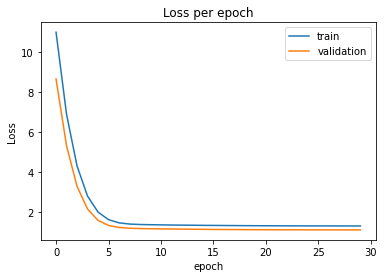

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_data )
plt.plot(loss_data_validation)
plt.title('Loss per epoch')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train','validation']);

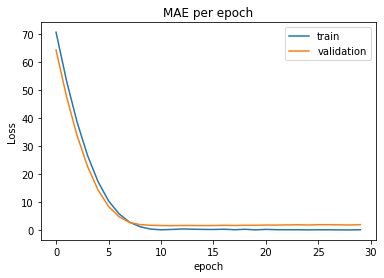

In [ ]:
import matplotlib.pyplot as plt

plt.plot(MAE )
plt.plot(MAE_validation)
plt.title('MAE per epoch')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train','validation']);

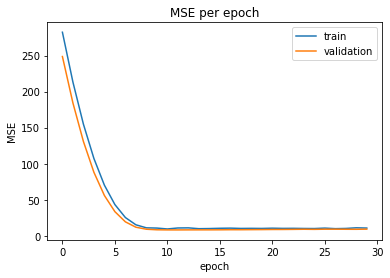

In [ ]:
import matplotlib.pyplot as plt

plt.plot(MSE)
plt.plot(MSE_validation)
plt.title('MSE per epoch')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend(['train','validation']);

2 model prediction :  tensor(4.9777, device='cuda:0') real number :  tensor(2.0000, device='cuda:0', dtype=torch.float64)

0 model prediction :  tensor(5.5498, device='cuda:0') real number :  tensor(21., device='cuda:0', dtype=torch.float64)

1 model prediction :  tensor(4.4058, device='cuda:0') real number :  tensor(0., device='cuda:0', dtype=torch.float64)

3 model prediction :  tensor(6.0680, device='cuda:0') real number :  tensor(5., device='cuda:0', dtype=torch.float64)

MAE for test:  tensor(2.5828, device='cuda:0', dtype=torch.float64)
MSE for test : tensor(13.8137, device='cuda:0', dtype=torch.float64)


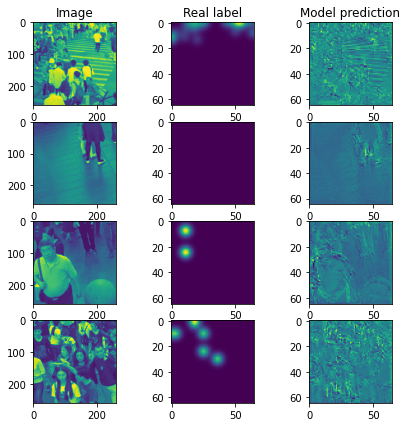

In [ ]:
fig, axs = plt.subplots(4,3,figsize=(7,7))
count = 0
a = 2
mae_test = 0
mse_test = 0

rand = []
for l in range(0,4):
    rand.append(random.randint(0,8))

for k, data_test in enumerate(testloader):
    with torch.no_grad():
        # get the inputs; data is a list of [inputs, labels]
        inputs_test, targets_test = data_test[0].to(device), data_test[1].to(device)
        y_pred_test = net(inputs_test.float())
        mae_test += abs(targets_test.sum() - y_pred_test.sum())/y_pred_test.shape[0]
        mse_test += (targets_test.sum() - y_pred_test.sum())**2/y_pred_test.shape[0]
        
        
        axs[0][0].set_title('Image')
        axs[0][1].set_title('Real label')
        axs[0][2].set_title('Model prediction')
        
        
        for h in range(0,4):
            if k == rand[h]:

                  
                  axs[h][2].imshow(y_pred_test[0][0].cpu())
                  axs[h][1].imshow(targets_test[0].cpu())
                  axs[h][0].imshow(inputs_test[0][0].cpu())
                  
                  print(h,"model prediction : " , y_pred_test[0].sum() , "real number : ", targets_test[0].sum())
                  print()

mae_test = mae_test/k
mse_test = (mse_test/k)**0.5
print("MAE for test: " ,mae_test )
print("MSE for test :" , mse_test)

In [ ]:
for i in range(8):
  a = y_pred_test[i][0].sum().cpu()
  b = targets[i].sum().cpu()
  print(i , ":", "models",int(a) ,"real",int(b))


0 : models 5 real 0
1 : models 5 real 4
2 : models 5 real 1
3 : models 5 real 52
4 : models 5 real 0
5 : models 5 real 23
6 : models 5 real 0
7 : models 5 real 0


In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/DL_2_q_2_v_4.pth'
torch.save(net.state_dict(), PATH)

# Augmentation

In [ ]:
X_train_aug = []
y_train_aug = []

aug = iaa.Affine( translate_percent={"x": 0.05 , "y":0.1},rotate=(-50, 45) ,scale=0.9  )
for i in range(len(y_train)):
    temp_1 = aug.augment_images([X_train_normal[i]])
    X_train_aug.append(temp_1[0])
    temp = aug.augment_images([y_train[i]])
    y_train_aug.append(temp[0])


In [ ]:
X_train_aug[10].shape

(1, 260, 260)

In [ ]:
trainset_aug = list(zip(X_train_aug ,y_train_aug))

In [ ]:
trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=16,
                                          shuffle=True, num_workers=2)

In [ ]:
net_aug = Net()
net_aug.to(device)
optimizer = torch.optim.Adam(net_aug.parameters() , lr=1e-7)

torch.Size([16, 260, 260])

In [ ]:

loss_data_aug = []
loss_data_validation_aug = []
MAE_aug = []
MSE_aug = []
MAE_validation_aug = []
MSE_validation_aug = []
for epoch in range(30):  # loop over the dataset multiple times

    #train
    running_loss = 0.0
    mae = 0
    mse = 0
    for i, data in enumerate(trainloader_aug, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net_aug(inputs.float())
        
        mae += abs(targets.sum() - outputs.sum())/outputs.shape[0]
        mse += (targets.sum() - outputs.sum())**2/outputs.shape[0]
   


        loss = euclidean_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print("dddd" ,running_loss)
    #print('epoch %d -> loss: %.3f' %(epoch + 1, running_loss/i ))


    #validation
    running_loss_val = 0.0
    mae_val = 0
    mse_val = 0
    for j, data_val in enumerate(validationloader, 0):
      with torch.no_grad():
        # get the inputs; data is a list of [inputs, labels]
        inputs_val, targets_val = data_val[0].to(device), data_val[1].to(device)

        
        outputs_val = net_aug(inputs_val.float())
        loss_val = euclidean_loss(outputs_val, targets_val)
        mae_val += abs(targets_val.sum() - outputs_val.sum())/outputs_val.shape[0]
        mse_val += (targets_val.sum() - outputs_val.sum())**2/outputs_val.shape[0]


        running_loss_val += loss_val.item()
    print('epoch %d : loss: %.3f   ,  validation loss: %.3f' %(epoch + 1, running_loss/i  ,  running_loss_val/j ))

    loss_data_aug.append(running_loss/i)
    loss_data_validation_aug.append(running_loss_val/j)
    MAE_aug.append(mae/i)
    MSE_aug.append(math.sqrt(mse/i))
    MAE_validation_aug.append(mae_val/j)
    MSE_validation_aug.append(math.sqrt(mse_val/j))

print('Finished Training')

epoch 1 : loss: 31.498   ,  validation loss: 31.491
epoch 2 : loss: 25.062   ,  validation loss: 24.857
epoch 3 : loss: 19.650   ,  validation loss: 19.311
epoch 4 : loss: 15.122   ,  validation loss: 14.792
epoch 5 : loss: 11.416   ,  validation loss: 11.128
epoch 6 : loss: 8.402   ,  validation loss: 8.243
epoch 7 : loss: 6.127   ,  validation loss: 6.046
epoch 8 : loss: 4.418   ,  validation loss: 4.389
epoch 9 : loss: 3.158   ,  validation loss: 3.200
epoch 10 : loss: 2.297   ,  validation loss: 2.387
epoch 11 : loss: 1.729   ,  validation loss: 1.855
epoch 12 : loss: 1.371   ,  validation loss: 1.521
epoch 13 : loss: 1.156   ,  validation loss: 1.325
epoch 14 : loss: 1.035   ,  validation loss: 1.216
epoch 15 : loss: 0.970   ,  validation loss: 1.162
epoch 16 : loss: 0.941   ,  validation loss: 1.137
epoch 17 : loss: 0.929   ,  validation loss: 1.127
epoch 18 : loss: 0.925   ,  validation loss: 1.122
epoch 19 : loss: 0.924   ,  validation loss: 1.120
epoch 20 : loss: 0.923   ,  va

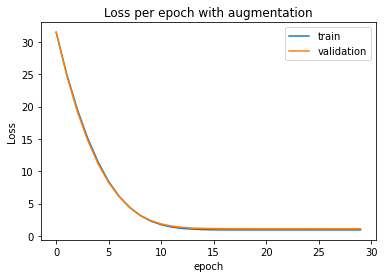

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_data_aug )
plt.plot(loss_data_validation_aug)
plt.title('Loss per epoch with augmentation')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train','validation']);

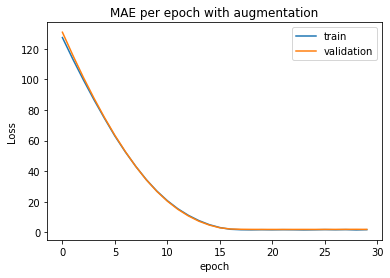

In [ ]:
import matplotlib.pyplot as plt

plt.plot(MAE_aug )
plt.plot(MAE_validation_aug)
plt.title('MAE per epoch with augmentation')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train','validation']);

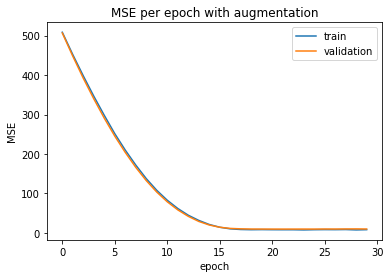

In [ ]:
import matplotlib.pyplot as plt

plt.plot(MSE_aug)
plt.plot(MSE_validation_aug)
plt.title('MSE per epoch with augmentation')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend(['train','validation']);

2 model prediction :  tensor(4.2935, device='cuda:0') real number :  tensor(2.0000, device='cuda:0', dtype=torch.float64)

0 model prediction :  tensor(3.7124, device='cuda:0') real number :  tensor(21., device='cuda:0', dtype=torch.float64)

1 model prediction :  tensor(5.6637, device='cuda:0') real number :  tensor(0., device='cuda:0', dtype=torch.float64)

3 model prediction :  tensor(4.0122, device='cuda:0') real number :  tensor(5., device='cuda:0', dtype=torch.float64)

MAE for test:  tensor(2.5435, device='cuda:0', dtype=torch.float64)
MSE for test : tensor(14.6539, device='cuda:0', dtype=torch.float64)


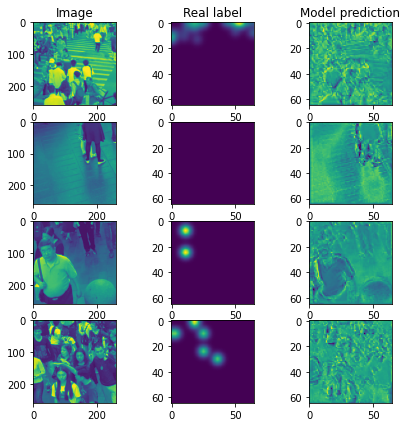

In [ ]:
fig, axs = plt.subplots(4,3,figsize=(7,7))

a = 2
mae_test_aug = 0
mse_test_aug = 0


for k, data_test in enumerate(testloader):
    with torch.no_grad():
        # get the inputs; data is a list of [inputs, labels]
        inputs_test_aug, targets_test_aug = data_test[0].to(device), data_test[1].to(device)
        y_pred_aug = net_aug(inputs_test_aug.float())
        mae_test_aug += abs(targets_test_aug.sum() - y_pred_aug.sum())/y_pred_aug.shape[0]
        mse_test_aug += (targets_test_aug.sum() - y_pred_aug.sum())**2/y_pred_aug.shape[0]
        
        
        axs[0][0].set_title('Image')
        axs[0][1].set_title('Real label')
        axs[0][2].set_title('Model prediction')
        
        
        for h in range(0,4):
            if k == rand[h]:

                  
                  axs[h][2].imshow(y_pred_aug[0][0].cpu())
                  axs[h][1].imshow(targets_test_aug[0].cpu())
                  axs[h][0].imshow(inputs_test_aug[0][0].cpu())
                  
                  print(h,"model prediction : " , y_pred_aug[0].sum() , "real number : ", targets_test_aug[0].sum())
                  print()

mae_test_aug = mae_test_aug/k
mse_test_aug = (mse_test_aug/k)**0.5
print("MAE for test: " ,mae_test_aug )
print("MSE for test :" , mse_test_aug)

In [ ]:
for i in range(8):
  a = y_pred_aug[i][0].sum().cpu()
  b = targets_test_aug[i].sum().cpu()
  print(i , ":", "models",int(a) ,"real",int(b))

0 : models 3 real 41
1 : models 4 real 2
2 : models 4 real 0
3 : models 4 real 1
4 : models 4 real 19
5 : models 4 real 30
6 : models 4 real 14
7 : models 4 real 6
